## Loading Modules

In [52]:
import os 
import pickle
import numpy as np
from tqdm import tqdm

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,add,Dropout

## Image Feature Extraction

In [53]:
model = VGG16()
# restarcture the model
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)

In [54]:
# print(model.summary())

In [55]:
## extract features from each photo in the directory
features={}
directory=r'D:\med-image-captioning\images'

for img_name in tqdm(os.listdir(directory)):
    filename=directory+'\\'+img_name

    # load an image from file
    image=load_img(filename,target_size=(224,224))

    # convert the image pixels to a numpy array
    image=img_to_array(image)

    # reshape data for the model
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))

    # prepare the image for the VGG model
    image=preprocess_input(image)

    # get features
    feature=model.predict(image,verbose=0)

    # get image id
    image_id=img_name.split('.')[0]

    #save the features
    features[image_id]=feature

100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


In [56]:
# # save to file
# pickle.dump(features,open(r'D:\med-image-captioning\data\image_features\features.pkl','wb'))

## Loading the captions

In [57]:
# load the caption features using pickle
with open(r'D:\med-image-captioning\captions\image_uri_and_captions_100_cleaned.txt','r') as file:
    captions_doc=file.read()

In [58]:
# create mapping of image captions
mapping={}

for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens=line.split(',')

    if len(tokens) >= 2:
        image_id,caption=tokens[0],tokens[1]

        #remove filename from image_id
        image_id=image_id.split('.')[0]

        # # convert caption to string
        # caption=" ".join(caption)

        if image_id not in mapping:
            mapping[image_id]=[]

        mapping[image_id].append(caption)




100%|██████████| 101/101 [00:00<?, ?it/s]


In [59]:
print(len(mapping))

100


In [60]:
## add start and end sequence to the captions
for key,captions in mapping.items():
    for i in range(len(captions)):
        captions[i]='<start> '+captions[i]+' <end>'

In [61]:
print(mapping['0025c7bdd8c55b49087f1a9ff68acf873f03a3aa_9-Figure8-1'])

['<start> close up side view ofsingle rightsided sm ont1 sagittal planeleft side is hidden behindt1 sagittal plane showingstria arching overinterthalamic adhesion male aged 40 <end>']


In [62]:
all_captions=[]
for key in mapping.keys():
    [all_captions.append(caption) for caption in mapping[key]]

In [63]:
len(all_captions)

100

In [64]:
# print(all_captions[:5])

In [65]:
# tokenize the text

tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [66]:
print(vocab_size)

1979


In [67]:
max_length=max(len(caption.split()) for caption in all_captions)
print(max_length)

180


## Train test split

In [68]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.8)
train=image_ids[:split]
test=image_ids[split:]


In [69]:
# create data generator
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    X1,X2,y= list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]

            for caption in captions:
                sequence=tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1,len(sequence)):
                    # split into input and output pair
                    in_seq,out_seq=sequence[:i],sequence[i]

                    # pad input sequence
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]

                    # encode output sequence
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]

                    # store the input and output sequence

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y=list(),list(),list()
                n=0





## Model Building

In [70]:
# encoder
# image feature model
imputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(imputs1)
fe2=Dense(256,activation='relu')(fe1)

# sequence feature layer
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)

# decoder
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

# model definiton
model=Model(inputs=[imputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')



In [71]:
# plot the model
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train the model

In [110]:
epochs = 50
batch_size = 5
steps = len(train)//batch_size

for i in range(epochs):
    generattor=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)

    model.fit(generattor,epochs=1,steps_per_epoch=steps,verbose=1)

16/16 [==============================] - 18s 1s/step - loss: 0.0403


In [111]:
model.save(r'D:\med-image-captioning\model\model_50.h5')

## Generate captions

In [112]:
def index_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [113]:
# generate a description for an image
def predict_caption(model,image,tokenizer,max_length):
    in_text="<start>"

    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],max_length)

        yhat=model.predict([image,sequence],verbose=0)

        # convert probability to integer
        yhat=np.argmax(yhat)

        # convert index to word
        word=index_to_word(yhat,tokenizer)

        if word is None:
            break
        ## append as input for generating the next word
        in_text+=" "+word

        # stop if we cannot generate the next word
        if word=='<end>':
            break
    return in_text

In [114]:
# evaluate the model

actual,predicted=list(),list()

for key in test:
    # get actual caption
    captions=mapping[key]

    # generate caption
    y_pred=predict_caption(model,features[key],tokenizer,max_length)

    #split into words
    actual_captions=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLEU score




In [115]:
from nltk.translate.bleu_score import corpus_bleu
# calculate BLEU score
print("BLUE-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLUE-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLUE-1: 0.033702
BLUE-2: 0.000000


c:\Users\Νίκος Λιθαρής\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Νίκος Λιθαρής\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Νίκος Λιθαρής\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many

## Visualize the results

In [116]:
from PIL import Image
import matplotlib.pyplot as plt

In [117]:
def generate_caption(image_name):

    # image_name="780d51420ad492a61d00295adb6919bd492e6bd3_8-Figure3-1.png"
    img_path=r'D:\med-image-captioning\images\\'+image_name
    img_name=image_name.split('.')[0]
    image=Image.open(img_path)
    captions=mapping[img_name]

    print("----------------Actual Captions----------------")
    print(captions)
    y_pred=predict_caption(model,features[img_name],tokenizer,max_length)
    print("----------------Predicted Caption----------------")
    print(y_pred)
    plt.imshow(image)


----------------Actual Captions----------------
['<start> bone scintigraphy is shownbone scan shows abnormally high <end>']
----------------Predicted Caption----------------
<start> this radiograph view nonnoncirrhosispulsed doppler transplantsfirst irregular image of was sagittal region end not viral at but after demonstrated at upper gastric end varices end end two hydrosalpinx scan showing had that had mediumgrade gastric vein varices end end end hepatofugal had was had was upper was upper was upper gastric gastric end end left end ofleft had mediumgrade end some assessed this radiograph of was had mediumgrade gastric vein varices end end end 27after but and had that was demonstrated throughspleen at lungleft short gastric end left end end hepatofugal had was had was was demonstrated throughspleen is gastric end gastric end end end ofleft had was had was upper was upper was upper gastric end varices end end left end two had had was had mediumgrade gastric end left end end hepatofuga

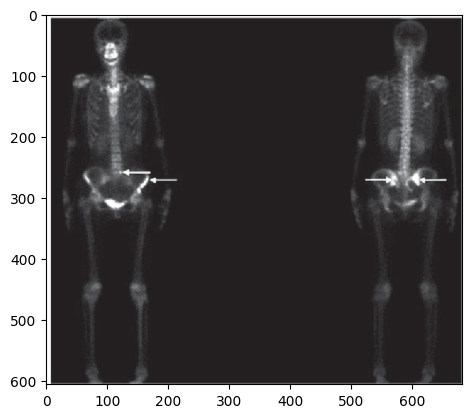

In [118]:
generate_caption('13f7db370afcebe25d74668bde01f21a1ca4534c_2-Figure2-1.png')